In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
suits = ['clubs', 
         'hearts',
         'diamonds',
         'spades']

names = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
values = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10])

def find_sets(cards):
    set_sums = np.sum(cards, axis=1)
    set_mask = set_sums >= 3
    set_vals = values[set_mask]
    set_inds = np.arange(13)[set_mask]
    set_cards = cards * set_mask.reshape(-1, 1)
    set_lengths = set_sums[set_mask]
    return set_cards.astype(bool), set_lengths, set_vals, set_inds

def find_runs(cards):
    run_cards = np.zeros((13, 4))
    run_lengths = []
    run_vals = []
    run_inds = []
    for i in range(4):
        on_run = False
        run_length = 0
        for j in range(11):
            if not on_run:
                if np.all(cards[j: j + 3, i]):
                    run_cards[j: j + 3, i] = 1
                    on_run = True
                    run_length = 3
                    run_vals.append(values[j])
                    run_inds.append((j, i))
            else:
                if cards[j + 2, i]:
                    run_length += 1
                    run_cards[j + 2, i] = 1
                else:
                    run_lengths.append(run_length)
                    on_run=False
                    run_length = 0
        if run_length:
            run_lengths.append(run_length)
                
    
    return run_cards.astype(bool), run_lengths, run_vals, run_inds

def find_deadwoods(cards):
    used_cards = find_runs(cards)[0]|find_sets(cards)[0]

    return cards&(~used_cards)

class Hand():
    def __init__(self, cards=None):
        if cards is None:
            self.cards = np.zeros((13, 4), dtype=bool)
        else:
            self.cards = cards.astype(bool)
    
    def print_hand(self):
        out_str = ''
        for i in range(13):
            for j in range(4):
                if self.cards[i, j]:
                    out_str += ' %s%s ' % (names[i], suits[j][0])
        
        return out_str.strip()
    
    def sets(self):
        return find_sets(self.cards)
    
    def runs(self):
        return find_runs(self.cards)
    
    def deadwoods(self):
        return find_deadwoods(self.cards)
    
    def find_min_points(self, n_cards=None):
        if n_cards is None:
            n_cards = np.sum(self.cards)
        sets = self.sets()[0]
        runs = self.runs()[0]
        deadwoods = self.deadwoods()
        
        allocations = np.zeros((13, 4))
        
        # 0 for empty
        # 1 for deadwoods
        # 2 for sets
        # 3 for runs
        # 4 for uncertain
        allocations[deadwoods] = 1
        allocations[sets] = 2
        allocations[runs] = 3
        uncertain = sets&runs
        allocations[uncertain] = 4

        best_allocation, best_points = solve_hand(allocations, n_cards=n_cards)
        print("solved")
        return best_allocation, best_points

def fix_hand(allocations):
    sets = find_sets(allocations == 2)[0]
    runs = find_runs(allocations == 3)[0]
    unused_cards = (allocations != 0)&(~(sets|runs))
    allocations[unused_cards] = 1
    
    return allocations

def evaluate_hand(allocations, n_cards=None):
    sets, set_lengths, set_vals, set_inds = find_sets(allocations == 2)
    runs, run_lengths, run_vals, run_inds = find_runs(allocations == 3)
    deadwoods = (allocations > 0)&(~(sets|runs))
    allocations[deadwoods] = 1
    deadwood_vals = np.array([values] * 4).T[allocations == 1]
    total_cards = np.sum(allocations != 0)
    if n_cards is None:
        n_cards = total_cards
    used_cards = sets|runs
    n_used_cards = np.sum(used_cards)
    # We have the exact right number of cards used
    if n_used_cards == n_cards:
        return 0
    # We have too few cards used
    elif n_used_cards < n_cards:
        return sum(sorted(list(deadwood_vals))[:n_cards - n_used_cards])
    # We need to take only a subset of the cards used
    if n_cards >= 3:
        set_leftovers = np.array(set_lengths) - 3
        run_leftovers = np.array(run_lengths) - 3
        all_leftovers = sorted(list(set_leftovers) + list(run_leftovers))
        pieces_available = min(int(n_cards / 3), len(all_leftovers)) # That is the total number of sets and runs
        leftovers_available = sum(all_leftovers[-pieces_available:])
        cards_needed = n_cards - 3 * pieces_available
        if leftovers_available >= cards_needed:
            return 0
        n_cards = cards_needed - leftovers_available
        assert n_cards < 3

    if len(run_vals):
        min_run = np.min(run_vals)
    else:
        min_run = 1000
    if len(set_vals):
        min_set = np.min(set_vals)
    else:
        min_set = 1000
    min_deadwoods = (sorted(list(deadwood_vals)) + [1000, 1000])[:2]
    if n_cards == 1:
        return min(min_run, min_set, min_deadwoods[0])
    elif n_cards == 2:
        return min(2 * min_run + 1, 
                   2 * min_set,
                   min_run + min_deadwoods[0], 
                   min_set + min_deadwoods[0],
                   min_deadwoods[0] + min_deadwoods[1])
    print(allocations)
    print(n_cards)
    assert False
                    
def get_inds(num, n_digits):
    inds = np.zeros(n_digits).astype(bool)
    for i in range(n_digits):
        if num % 2:
            inds[i] = True
        num = int(num / 2)
    return inds

def solve_hand(cards, n_cards=None):
    if n_cards is None:
        n_cards = np.sum(cards)
    sets = find_sets(cards)[0]
    runs = find_runs(cards)[0]
    used_cards = sets|runs
    deadwoods = cards&(~used_cards)

    allocations = np.zeros((13, 4))

    # 0 for empty
    # 1 for deadwoods
    # 2 for sets
    # 3 for runs
    # 4 for uncertain
    allocations[deadwoods] = 1
    allocations[sets] = 2
    allocations[runs] = 3
    uncertain = sets&runs
    allocations[uncertain] = 4
    
    uncertain_inds = np.where(allocations.ravel() == 4)[0]
    if not len(uncertain_inds):
        return allocations, evaluate_hand(allocations, n_cards=n_cards)
    # Range through all permutations of each uncertain card being in a set or a run
    n_uncertain = len(uncertain_inds)
    best_allocation = None
    best_points = 100000
    for i in range(2 ** n_uncertain):
        set_inds = get_inds(i, n_uncertain)
        run_inds = ~set_inds
        allocation_i = allocations.ravel().copy()
        allocation_i[uncertain_inds[set_inds]] = 2
        allocation_i[uncertain_inds[run_inds]] = 3
        allocation_i = allocation_i.reshape((13, 4))
        points_i = evaluate_hand(allocation_i, n_cards=n_cards)
        if points_i == 0:
            best_allocation = allocation_i
            best_points = points_i
            break
        if points_i < best_points:
            best_points = points_i
            best_allocation = allocation_i
    return fix_hand(best_allocation), best_points
        
        
    
    
# h = Hand()
# h.cards[[2, 2, 4, 6, 8], : 3] = 1
# solve_hand(h.cards, 10) # 3

# h = Hand()
# h.cards[2] = 1
# t0 = time()
# solve_hand(h.cards, 3) # 0
# print(time() - t0)

# h = Hand()
# h.cards[:, 0] = 1
# solve_hand(h.cards, 10) # 0

# h = Hand()
# h.cards[:, 0] = 1
# h.cards[5, : 3] = 1
# solve_hand(h.cards, 3) # 0

# h = Hand()
# h.cards[[3, 4, 5], :3] = 1
# h.cards[6, 0] = 1
# h.cards[3, 3] = 1
# solve_hand(h.cards, 7) # 0

# h = Hand()
# h.cards[[1, 3, 4, 5, 8, 9, 10], 0] = 1
# h.cards[-1, :2] = 1
# solve_hand(h.cards, 5) # 6

# h = Hand()
# h.cards[[3, 4, 5], 0] = 1
# h.cards[5] = 1
# solve_hand(h.cards, 5) # 4

# h = Hand()
# h.cards[[2, 4]] = 1
# solve_hand(h.cards, 6) # 0

# h = Hand()
# h.cards[2] = 1
# solve_hand(h.cards, 1) # 3
# solve_hand(h.cards, 2) # 6

# h = Hand()
# h.cards[[0, 2, 3, 4 ,5, 9], 3] = 1
# solve_hand(h.cards, 5) # 1

# h = Hand()
# h.cards[[0, 2, 3, 4 ,5, 9], 3] = 1
# solve_hand(h.cards, 5)# 1

In [3]:
class Hand():
    def __init__(self, cards=None, deck=None):
        if cards is None:
            self.cards = np.zeros((13, 4), dtype=bool)
        else:
            self.cards = cards.astype(bool)
        
        self.deck = deck
    
    def deal(self, n_cards, remove=True):
        dealable_cards = np.where(self.cards.flatten())[0]
        dealt_cards = np.random.choice(dealable_cards, n_cards, False)
        deal = np.zeros(52)
        deal[dealt_cards] = 1
        deal = deal.reshape((13, 4)).astype(bool)
        if remove:
            self.cards[deal] = False
        dealt_hand = Hand(deal)
        
        return dealt_hand
    
    def add(self, new_cards, remove=False):
        if type(new_cards) is Hand:
            assert ~np.any(self.cards&new_cards.cards)
            self.cards = self.cards|new_cards.cards
            if remove:
                new_cards.cards[:] = False
        else:
            number, suit = new_cards
            assert ~self.cards[number, suit]
            self.cards[number, suit] = True

    def remove(self, new_cards, remove=False):
        if type(new_cards) is Hand:
            assert np.all(self.cards >= new_cards.cards)
            self.cards = self.cards^new_cards.cards
        else:
            number, suit = new_cards
            assert self.cards[number, suit]
            self.cards[number, suit] = False
    
    def check_integrity(self):
        if self.deck is not None:
            return self.deck.check_integrity()
        return True

    def print_hand(self):
        out_str = ''
        for i in range(13):
            for j in range(4):
                if self.cards[i, j]:
                    out_str += '%s%s ' % (names[i], suits[j][0])
        
        return out_str.strip()
    
    def show_cards(self):
        return self.cards.copy()
    
    def length(self):
        return np.sum(self.cards)
    
    def copy(self):
        return Hand(self.cards.copy())
    
class IntegrityError(Exception):
    pass

class Deck():
    def __init__(self):
        self.base = Hand(np.ones((13, 4)))
        self.hands = [self.base]
    
    def deal(self, n_cards, recipient=None, track=True, remove=True):
        dealt_hand = self.base.deal(n_cards, remove=remove)
        if recipient is not None:
            recipient.add(dealt_hand)
        if track:
            if recipient is None: 
                dealt_hand.deck = self
                self.hands.append(dealt_hand)
            else:
                if recipient not in self.hands:
                    recipient.deck = self
                    self.hands.append(recipient)
            
        return dealt_hand
    
    def check_integrity(self):
        counts = np.zeros((13, 4))
        for hand in self.hands:
            counts += hand.cards.astype(int)
        if ~np.all(counts == 1):
            raise IntegrityError()

class Agent():
    def __init__(self):
        pass
    
    def pass_hand(self, see_hand):
        self.see_hand = see_hand 

    def pass_upcard(self, see_upcard):
        self.see_upcard = see_upcard
    
    def pass_discard_pile(self, see_discard_pile):
        self.see_discard_pile = see_discard_pile
    
    def log(self, message):
        print('[%s] %s' % (self.name, message))


class HumanAgent(Agent):
    def __init__(self, name):
        self.name = name
    
    def print_discard_pile(self):
        pile = Hand(self.see_discard_pile())
        self.log("Discard pile:")
        self.log(pile.print_hand())
        
    def check_upcard(self):
        hand = Hand(self.see_hand())
        upcard = Hand(self.see_upcard())
        self.log("Your hand")
        self.log(hand.print_hand())
        self.log("Upcard")
        self.log(upcard.print_hand())
        while True:
            accept = input("Would you like to take the upcard (y/n or d to see discard pile) ") # Give option to see discard_pile
            if accept.lower() == 'y':
                return True
            if accept.lower() == 'n':
                return False
            if accept.lower() == 'd':
                self.print_discard_pile()
                continue
            self.log("Invalid input")
    
    def draw_from_deck(self, draw_card):
        card = Hand(draw_card())
        self.log("You draw %s from the deck." % card.print_hand())
    
    def discard(self):
        hand = Hand(self.see_hand())
        self.log("Choose one of the following to discard: ")
        discard_str = ''
        for i, card in enumerate(hand.print_hand().split(' ')):
            self.log(str(i) + ': ' + card)
        while True:
            discard = input("Enter a card index to discard (0 - %d or d to see discard pile): " % (hand.length() - 1))
            if discard.lower() == 'd':
                self.print_discard_pile()
                continue
            try:
                discard_ind = int(discard)
            except ValueError:
                self.log("Invalid input")
                continue
                
            card_idxs = np.where(hand.cards.flatten())[0]
            try:
                discard_idx = card_idxs[discard_ind]
            except IndexError:
                self.log("Invalid input")
                continue
                
            discard_hand = np.zeros(52)
            discard_hand[discard_idx] = 1
            discard_hand = Hand(discard_hand.reshape(13, 4))
            self.log("You discard %s" % discard_hand.print_hand())
            return discard_hand
        
    
    def query_go_down(self):
        cards = self.see_hand()
        _, points = solve_hand(cards)
        if points:
            if points <= 10:
                while True:
                    go_down_str = input("You have %d points, would you like to knock? (y/n) " % points)
                    if go_down_str.lower() == 'y':
                        return True
                    if go_down_str.lower() == 'n':
                        return False
                    self.log("Invalid input")
            else:
                return False
        else:
            while True:
                go_down_str = input("You have gin, would you like to go down? (y/n) ")
                if go_down_str.lower() == 'y':
                    return True
                if go_down_str.lower() == 'n':
                    return False
                self.log("Invalid input")
    
    def view_opponent_draw(self, took_upcard):
        if took_upcard:
            upcard = Hand(self.see_upcard())
            self.log("Your opponent takes the upcard: %s" % upcard.print_hand())
        else:
            self.log("Your opponent draws a card from the deck")

    def view_opponent_discard(self):
        upcard = Hand(self.see_upcard())
        self.log("Your opponent discards: %s" % upcard.print_hand())
    
        
class Gin():
    def __init__(self, agent1, agent2, cards_in_hand=10):
        self.cards_in_hand = cards_in_hand
        self.agent1 = agent1
        self.agent2 = agent2
        
        self.deck = Deck()
        
        self.hand1 = Hand()
        self.hand2 = Hand()
        self.upcard = Hand()
        self.discard_pile = Hand()
        
        self.agent1.pass_hand(self.hand1.show_cards)
        self.agent1.pass_upcard(self.upcard.show_cards)
        self.agent1.pass_discard_pile(self.discard_pile.show_cards)
        
        self.agent2.pass_hand(self.hand2.show_cards)
        self.agent2.pass_upcard(self.upcard.show_cards)
        self.agent2.pass_discard_pile(self.discard_pile.show_cards)
        
        self.turn = 0
        
    def print_game_state(self, show_deck=False):
        hands = [self.hand1, self.hand2, self.upcard, self.discard_pile]
        names = ['hand1', 'hand2', 'upcard', 'discard_pile']
        print("Turn: %d" % self.turn)
        for hand, name in zip(hands, names):
            print(name)
            print(hand.print_hand())
        if show_deck:
            print('deck')
            print(self.deck.base.print_hand())
    
    def check_win(self):
        if self.turn == 0:
            down_hand = self.hand1
            down_name = self.agent1.name
            opponent_hand = self.hand2
            opponent_name = self.agent2.name
        else:
            down_hand = self.hand2
            down_name = self.agent2.name
            opponent_hand = self.hand1
            opponent_name = self.agent1.name
        
        _, down_points = solve_hand(down_hand.cards)
        _, opponent_points = solve_hand(opponent_hand.cards)
        print("%s's hand:" % down_name)
        print(down_hand.print_hand())
        print("%s's hand:" % opponent_name)
        print(opponent_hand.print_hand())
        if down_points > 10:
            print("%s has more than 10 points (%d) and is not allowed to go down." % (down_name, down_points))
            return False
        elif down_points:
            if opponent_points >= down_points:
                print("%s knocks with %d points and %s has %d points, so %s nets %d points" % (
                    down_name, down_points, opponent_name, opponent_points, down_name, opponent_points - down_points))
        else:
            print("%s has gin and %s has %d points, so %s nets %d points" % (
                    down_name, opponent_name, opponent_points, down_name, opponent_points + 25))
        return True
    
    def play(self):
        # Setup, agent1 always goes first
        self.deck.deal(self.cards_in_hand, recipient=self.hand1)  
        self.deck.deal(self.cards_in_hand, recipient=self.hand2)
        self.deck.deal(1, recipient=self.upcard)
        self.deck.hands.append(self.discard_pile)
        
        self.deck.check_integrity()
        self.turn = 0
        playing = True
        while playing:
            for agent, other_agent, hand in zip([self.agent1, self.agent2], [self.agent2, self.agent1], [self.hand1, self.hand2]):
                accepted_up_card = agent.check_upcard()
                if accepted_up_card:
                    other_agent.view_opponent_draw(True)
                    hand.add(self.upcard, remove=True)
                else:
                    other_agent.view_opponent_draw(False)
                    self.discard_pile.add(self.upcard, remove=True)
                    drawn_card = self.deck.deal(1, recipient=hand)
                    agent.draw_from_deck(drawn_card.show_cards)
                    
                self.upcard.add(agent.discard())
                other_agent.view_opponent_discard()
                hand.remove(self.upcard)
                
                go_down = agent.query_go_down()
                if go_down:
                    valid_win = self.check_win()
                    if valid_win:
                        playing = False
                        break
                
                self.turn = (self.turn + 1) % 2
                self.deck.check_integrity()
                if self.deck.base.length() == 0:
                    # Reshuffle deck
                    pass

In [4]:
# game = Gin(HumanAgent("Player 1"), HumanAgent("Player 2"))
# game.play()

In [13]:
def evaluate_hand_montecarlo(hand, deck, n_cards=None, cards_to_take=5, iterations=100):
    points = np.zeros(iterations)
    if n_cards is None:
        n_cards = hand.length()
    for i in range(iterations):
        test_hand = hand.copy()
        test_hand.add(deck.deal(cards_to_take, remove=False), remove=False)
        points[i] = solve_hand(test_hand.cards, n_cards)[1]
    
    return points

class DeckEstimate():
    def __init__(self, suspicion_exponent=2):
        # -1: definitely not occupied
        # 0: maybe occupied
        # 1: definitely occupied
        self.deck = np.zeros((13, 4))
        self.opponents_hand = np.zeros((13, 4))
        
        # Number of observations suggesting occupied - 
        # number of observations suggesting unoccupied
        self.opponents_hand_suspicions = np.zeros((13, 4))
        self.suspicion_exponent = suspicion_exponent
    
    def print_estimate(self, log_fn=None):
        if log_fn is None:
            log_fn = print
        log_fn("Cards definitely in opponents hand: ")
        log_fn(Hand(self.opponents_hand == 1).print_hand())
        log_fn("Cards definitely not in opponents hand: ")
        log_fn(Hand(self.opponents_hand == -1).print_hand())
        log_fn("Cards suspected in opponents hand: ")
        log_fn(Hand(self.opponents_hand_suspicions > 0).print_hand())
        log_fn("Cards suspected not in opponents hand: ")
        log_fn(Hand(self.opponents_hand_suspicions < 0).print_hand())
        log_fn("Cards definitely in deck: ")
        log_fn(Hand(self.deck == 1).print_hand())
        log_fn("Cards definitely not in deck: ")
        log_fn(Hand(self.deck == -1).print_hand())
        
    def remove_from_deck(self, hand):
        self.deck[hand.cards] = -1
        self.clean_suspicions()
        
    def remove_from_opponents_hand(self, hand):
        self.opponents_hand[hand.cards] = -1
        self.clean_suspicions()
    
    def remove_from_both(self, hand):
        self.remove_from_deck(hand)
        self.remove_from_opponents_hand(hand)
        
    def add_to_deck(self, hand):
        self.deck[hand.cards] = 1
        self.remove_from_opponents_hand(hand)
        self.clean_suspicions()
    
    def add_to_opponents_hand(self, hand):
        self.opponents_hand[hand.cards] = 1
        self.remove_from_deck(hand)
        self.add_suspicion(hand)
        self.clean_suspicions()
    
    # Take into consideration fact that opponents 
    # will often discard high point-value cards even though
    # they have adjacent cards?
    def add_suspicion(self, hand):
        cards = hand.cards
        assert np.sum(cards) == 1
        num_a, suit_a = np.where(cards)
        num = num_a[0]
        suit = suit_a[0]
        self.opponents_hand_suspicions[num, :] += 1
        if num:
            self.opponents_hand_suspicions[num - 1, suit] += 1
        if num < len(cards) - 1:
            self.opponents_hand_suspicions[num + 1, suit] += 1
        self.clean_suspicions()

    def remove_suspicion(self, hand):
        cards = hand.cards
        assert np.sum(cards) == 1
        num_a, suit_a = np.where(cards)
        num = num_a[0]
        suit = suit_a[0]
        self.opponents_hand_suspicions[num, :] -= 1
        if num:
            self.opponents_hand_suspicions[num - 1, suit] -= 1
        if num < len(cards) - 1:
            self.opponents_hand_suspicions[num + 1, suit] -= 1
        self.clean_suspicions()
    
    def clean_suspicions(self):
        self.opponents_hand_suspicions[self.opponents_hand != 0] = 0
        self.opponents_hand_suspicions[self.deck == 1] = 0
    
    def deck_sampler(self):
        hand = Hand(self.deck != -1)
        return hand
    
    def sample_opponents_hand(self, n_cards, cards_to_add=None):
        # Returns a sampling of where there may or may not be cards in the opponents hand
        hand_frequencies = (self.opponents_hand == 0) * np.power(self.suspicion_exponent, self.opponents_hand_suspicions)
        if cards_to_add is not None:
            hand_frequencies[cards_to_add.cards] = 0
        hand_frequencies = hand_frequencies.flatten() / np.sum(hand_frequencies)
        sample_inds = np.random.choice(np.arange(52), n_cards, replace=False, p=hand_frequencies)
        hand_sample = np.zeros(52, dtype=bool)
        hand_sample[sample_inds] = True
        
        return Hand(hand_sample.reshape(13, 4))
        
    def evaluate_opponents_hand_montecarlo(self, n_cards, cards_to_add=None, cards_to_take=5, iterations=100):
        hand = Hand(self.opponents_hand == 1)
        if cards_to_add is not None:
            hand.add(cards_to_add)
        unknown_cards_in_hand = n_cards - hand.length()
        points = np.zeros(iterations)
        for i in range(iterations):
            test_hand = hand.copy()
            test_deck = Hand(self.deck >= 0)
            hand_sample = self.sample_opponents_hand(unknown_cards_in_hand, cards_to_add)
            test_deck.remove(hand_sample)
            deck_sample = test_deck.deal(cards_to_take)
            test_hand.add(hand_sample)
            test_hand.add(deck_sample)
            points[i] = solve_hand(test_hand.cards, n_cards)[1]
        return points
    
    def check_integrity(self):
        assert ~np.any((self.deck == 1)&(self.opponents_hand == 1))

class AIAgent(Agent):
    def __init__(self, name, mc_extra_cards=5, mc_iterations=100, debug=False):
        self.name = name
        self.mc_extra_cards = mc_extra_cards
        self.mc_iterations = mc_iterations
        self.deck_opponent_estimate = DeckEstimate()
        
        self.debug = debug
        
        self.deck_prepped = False
    
            
    def check_upcard(self):
        hand = Hand(self.see_hand())
        upcard = Hand(self.see_upcard())
        
        # Remove hand from deck if first turn
        if not self.deck_prepped:
            self.deck_opponent_estimate.remove_from_both(hand)
            self.deck_prepped = True
            
        # Remove upcard from deck
        self.deck_opponent_estimate.remove_from_both(upcard)
        
        hand_w_upcard = hand.copy()
        hand_w_upcard.add(upcard)
        hand_pts = evaluate_hand_montecarlo(
            hand, 
            self.deck_opponent_estimate.deck_sampler(), 
            n_cards=hand.length(), 
            cards_to_take=self.mc_extra_cards,
            iterations=self.mc_iterations)
    
        hand_w_upcard_pts = evaluate_hand_montecarlo(
            hand_w_upcard, 
            self.deck_opponent_estimate.deck_sampler(), 
            n_cards=hand.length(), 
            cards_to_take=self.mc_extra_cards - 1,
            iterations=self.mc_iterations)
        
        if self.debug:
            self.log("Hand: %s" % hand.print_hand())
            self.log("Hand points: %f" % hand_pts.mean())
            self.log("Upcard: %s" % upcard.print_hand())
            self.log("Hand w/ upcard points: %f" % hand_w_upcard_pts.mean())
        
        if hand_pts.mean() > hand_w_upcard_pts.mean():
            return True  # Take upcard
        return False  # Don't take upcard
                
    
    def draw_from_deck(self, draw_card):
        self.deck_opponent_estimate.remove_from_both(Hand(draw_card()))
        if self.debug:
            print("Drawn card: %s" % Hand(draw_card()).print_hand())
    
    def discard(self):
        hand = Hand(self.see_hand())
        card_idxs = np.where(hand.cards.flatten())[0]
        # Want to maximize this 
        discard_points = np.zeros(hand.length())
        default_opponent_points = self.deck_opponent_estimate.evaluate_opponents_hand_montecarlo(hand.length()).mean()
        for i, card_idx in enumerate(card_idxs):
            discard_card = np.zeros(52)
            discard_card[card_idx] = 1
            discard_hand = Hand(discard_card.reshape(13, 4))
            remaining_hand = hand.copy()
            remaining_hand.remove(discard_hand)
            points = evaluate_hand_montecarlo(
                remaining_hand, 
                self.deck_opponent_estimate.deck_sampler(), 
                n_cards=remaining_hand.length(), 
                cards_to_take=self.mc_extra_cards, 
                iterations=self.mc_iterations).mean()
            opponent_points_w_discard = self.deck_opponent_estimate.evaluate_opponents_hand_montecarlo(
                hand.length(), cards_to_add=discard_hand).mean()
            opponent_points = min(default_opponent_points, opponent_points_w_discard)
            discard_points[i] = opponent_points - points
            if self.debug > 1:
                self.log("Remaining Hand %d: %s" % (i, remaining_hand.print_hand()))
                self.log("Discard: %s" % discard_hand.print_hand())
                self.log("Points: %f\n" % points)
                self.log("Estimated opponent_points: %f\n" % opponent_points)
            
        best_discard_idx = card_idxs[np.argmax(discard_points)]
        best_discard_card = np.zeros(52)
        best_discard_card[best_discard_idx] = 1
        best_discard_hand = Hand(best_discard_card.reshape(13, 4)) 
        if self.debug:
            self.log("Chosen Discard: %s" % best_discard_hand.print_hand())
            self.deck_opponent_estimate.print_estimate(self.log)
        return best_discard_hand   
    
    def query_go_down(self):
        cards = self.see_hand()
        _, points = solve_hand(cards)
        print(Hand(cards).print_hand())
        print(points)
        if points:
            if points <= 10:
                return True
            return False
        else:
            return True
    
    def view_opponent_draw(self, took_upcard):
        hand = Hand(self.see_upcard())
        self.deck_opponent_estimate.remove_from_deck(hand)
        if took_upcard:
            self.deck_opponent_estimate.add_to_opponents_hand(hand)
            self.deck_opponent_estimate.add_suspicion(hand)
        else:
            self.deck_opponent_estimate.remove_from_opponents_hand(hand)
            self.deck_opponent_estimate.remove_suspicion(hand)
            
    def view_opponent_discard(self):
        hand = Hand(self.see_upcard())
        self.deck_opponent_estimate.remove_suspicion(hand)

In [14]:
game = Gin(HumanAgent("Player 1"), AIAgent("Player 2", debug=0))
game.play()

[Player 1] Your hand
[Player 1] Ac 2d 4h 6c 6h 7h 7d 10c 10d Jd
[Player 1] Upcard
[Player 1] 3d
Would you like to take the upcard (y/n or d to see discard pile) y
[Player 1] Choose one of the following to discard: 
[Player 1] 0: Ac
[Player 1] 1: 2d
[Player 1] 2: 3d
[Player 1] 3: 4h
[Player 1] 4: 6c
[Player 1] 5: 6h
[Player 1] 6: 7h
[Player 1] 7: 7d
[Player 1] 8: 10c
[Player 1] 9: 10d
[Player 1] 10: Jd
Enter a card index to discard (0 - 10 or d to see discard pile): 8
[Player 1] You discard 10c
[Player 1] Your opponent draws a card from the deck
[Player 1] Your opponent discards: Kd
2h 4s 5c 6d 6s 8d 9d 10h Jh Qs
70
[Player 1] Your hand
[Player 1] Ac 2d 3d 4h 6c 6h 7h 7d 10d Jd
[Player 1] Upcard
[Player 1] Kd
Would you like to take the upcard (y/n or d to see discard pile) n
[Player 1] You draw Js from the deck.
[Player 1] Choose one of the following to discard: 
[Player 1] 0: Ac
[Player 1] 1: 2d
[Player 1] 2: 3d
[Player 1] 3: 4h
[Player 1] 4: 6c
[Player 1] 5: 6h
[Player 1] 6: 7h
[Playe

15.9 9.853425800197614


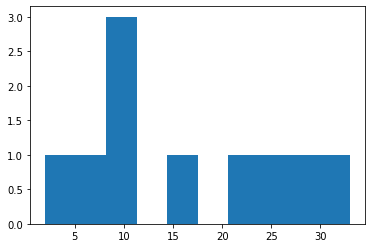

21.0 9.044335243676011


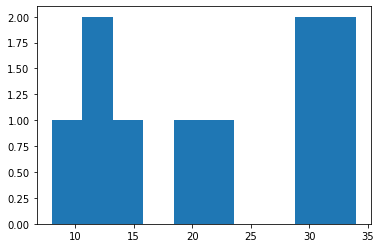

In [153]:
print(hand_pts.mean(), hand_pts.std())
plt.hist(hand_pts, bins=10)
plt.show()

print(hand_w_upcard_pts.mean(), hand_w_upcard_pts.std())
plt.hist(hand_w_upcard_pts, bins=10)
plt.show()

In [272]:
de = DeckEstimate()
remove_cards = np.zeros((13, 4))
remove_cards[3] = 1
remove_cards[9, 2] = 1
remove_cards[2, [0, 3]] = 1
de.remove_from_both(Hand(remove_cards))
add_cards = np.zeros((13, 4))
add_cards[7, 2] = 1
#add_cards[1, [0, 3]] = 1
de.add_to_opponents_hand(Hand(add_cards))
susp_card = np.zeros((13, 4))
susp_card[10, 1] = 1
de.add_suspicion(Hand(susp_card))
susp_card = np.zeros((13, 4))
susp_card[4, 2] = 1
de.add_suspicion(Hand(susp_card))
susp_card = np.zeros((13, 4))
susp_card[12, 3] = 1
de.remove_suspicion(Hand(susp_card))
print(de.opponents_hand)
print(de.deck)
print(de.opponents_hand_suspicions)

[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-1.  0.  0. -1.]
 [-1. -1. -1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [-1.  0.  0. -1.]
 [-1. -1. -1. -1.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  1.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 0.  1.  0. -1.]
 [-1. -1. -1. -1.]]


In [273]:
for i in range(10):
    print(de.sample_opponents_hand(10).print_hand())

3d 5d 6c 6s 7h 9h 9s 10h Jh Qs
2s 5c 5d 6c 6d 8s 9c 9s Jd Qh
5c 5d 6s 7d 8h 8s 9h 10h Jd Kc
2c 2d 2s 5h 6d 7d 10s Jc Js Qc
Ac 2c 5h 5s 6h 8h 8s Js Qh Kd
Ad 5d 5s 6s 7d 8s 10s Jc Jd Qh
As 2c 3d 5c 7d 8s 9d Jc Qh Ks
Ah 6h 6d 6s 7c 8c 10c Jh Qc Qd
Ac 2h 8c 9d 10h Jc Js Qd Kh Ks
Ac Ah 3h 3d 7s 8h 8s 9s Jd Qh


In [282]:
add_cards = np.zeros(52)
add_cards[0] = 1
add_hand = Hand(add_cards.reshape(13, 4))
de.evaluate_opponents_hand_montecarlo(10, cards_to_add=add_hand).mean()

21.88